In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Hyper Parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [5]:


# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


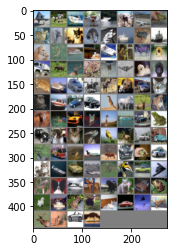

In [6]:
# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
# Neural Network

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) #input_size= 3 channels, output_size = 6, kernel:size = 5
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # 10 classes

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

model = CNN().to(device)  

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
# Trainning Loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # reshape input and push data to device
    images = images.to(device)
    labels = labels.to(device)
    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss= {loss.item():.4f}')
    


epoch 1/10, step 100/500, loss= 1.9368
epoch 1/10, step 200/500, loss= 1.6349
epoch 1/10, step 300/500, loss= 1.5570
epoch 1/10, step 400/500, loss= 1.4370
epoch 1/10, step 500/500, loss= 1.4510
epoch 2/10, step 100/500, loss= 1.2617
epoch 2/10, step 200/500, loss= 1.3363
epoch 2/10, step 300/500, loss= 1.4708
epoch 2/10, step 400/500, loss= 1.2172
epoch 2/10, step 500/500, loss= 1.3187
epoch 3/10, step 100/500, loss= 1.1558
epoch 3/10, step 200/500, loss= 1.2147
epoch 3/10, step 300/500, loss= 1.2161
epoch 3/10, step 400/500, loss= 1.4288
epoch 3/10, step 500/500, loss= 1.0826
epoch 4/10, step 100/500, loss= 1.0727
epoch 4/10, step 200/500, loss= 1.2077
epoch 4/10, step 300/500, loss= 1.1753
epoch 4/10, step 400/500, loss= 1.2481
epoch 4/10, step 500/500, loss= 1.1010
epoch 5/10, step 100/500, loss= 1.1468
epoch 5/10, step 200/500, loss= 1.0690
epoch 5/10, step 300/500, loss= 1.1123
epoch 5/10, step 400/500, loss= 1.0877
epoch 5/10, step 500/500, loss= 1.1616
epoch 6/10, step 100/500,

In [10]:
#save the model 

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [11]:
# Test

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # return the value and index (index = predictions)
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

  accuracy = 100.0 * n_correct / n_samples
  print(f'accuracy = {accuracy}')

accuracy = 63.84


In [12]:
# Extended test, with acc per class
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 63.84 %
Accuracy of plane: 71.7 %
Accuracy of car: 71.1 %
Accuracy of bird: 48.5 %
Accuracy of cat: 45.7 %
Accuracy of deer: 64.5 %
Accuracy of dog: 49.7 %
Accuracy of frog: 68.7 %
Accuracy of horse: 68.5 %
Accuracy of ship: 73.2 %
Accuracy of truck: 76.8 %
